<a href="https://colab.research.google.com/github/dkfma2060/dkfma2060/blob/main/Recycling_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd 
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import keras.applications.xception as xception
import zipfile
import sys
import time
import tensorflow.keras as keras
import tensorflow as tf
import re

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
#from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
# Increasing the image size didn't result in increasing the training accuracy
IMAGE_WIDTH = 320    
IMAGE_HEIGHT = 320
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3

# Path where our data is located
base_path = "/content/drive/MyDrive/recycling_data/training/"

# Dictionary to save our 11 classes
categories = {0: 'battery', 1: 'can', 2: 'clothes', 3: 'electronics', 4: 'glass', 5: 'light',
              6: 'paper', 7: 'plastic', 8: 'polystyrene', 9: 'trash', 10: 'vinyls'}

In [ ]:
import os
# 주어진 디렉토리에 있는 항목들의 이름을 담고 있는 리스트를 반환합니다.
# 리스트는 임의의 순서대로 나열됩니다.

#file_path = '/content/drive/MyDrive/recycling_data/training/can'
#file_path = '/content/drive/MyDrive/recycling_data/training/clothes'
#file_path = '/content/drive/MyDrive/recycling_data/training/electronics'
#file_path = '/content/drive/MyDrive/recycling_data/training/glass'
#file_path = '/content/drive/MyDrive/recycling_data/training/light'
#file_path = '/content/drive/MyDrive/recycling_data/training/paper'
#file_path = '/content/drive/MyDrive/recycling_data/training/plastic'
#file_path = '/content/drive/MyDrive/recycling_data/training/polystyrene'
#file_path = '/content/drive/MyDrive/recycling_data/training/trash'
file_path = '/content/drive/MyDrive/recycling_data/training/vinyls'

file_names = os.listdir(file_path)
file_names[0:5]

['vinyls1.jpg', 'vinyls2.jpg', 'vinyls3.jpg', 'vinyls4.jpg', 'vinyls5.jpg']

In [ ]:
i = 1
for name in file_names:
    src = os.path.join(file_path, name)
    #dst = 'can' + str(i) + '.jpg'
    #dst = 'clothes' + str(i) + '.jpg'
    #dst = 'electronics' + str(i) + '.jpg'
    #dst = 'glass' + str(i) + '.jpg'
    #dst = 'light' + str(i) + '.jpg'
    #dst = 'paper' + str(i) + '.jpg'
    #dst = 'plastic' + str(i) + '.jpg'
    #dst = 'polystyrene' + str(i) + '.jpg'
    #dst = 'trash' + str(i) + '.jpg'
    dst = 'vinyls' + str(i) + '.jpg'

    dst = os.path.join(file_path, dst)
    os.rename(src, dst)
    i += 1

In [ ]:
# Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("\d",x).start()] + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for i,category in enumerate(categories, start=0):
    filenames = os.listdir(base_path + categories[i])
    
    filenames_list = filenames_list  +filenames
    categories_list = categories_list + [category] * len(filenames)
    
df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))

number of elements =  17164


In [ ]:
df.head()

,filename,category
0,can/can1661.jpg,1
1,clothes/clothes853.jpg,2
2,plastic/plastic35.jpg,7
3,light/light1019.jpg,5
4,electronics/electronics86.jpg,3


In [ ]:
from tensorflow.keras.preprocessing import image

plastic/plastic537.jpg


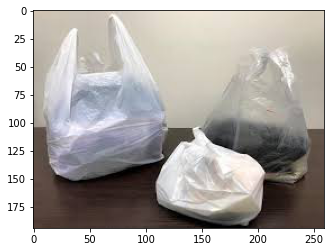

In [ ]:
# see sample image, you can run the same cell again to get a different image
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = image.load_img(base_path + sample['filename'])
print(sample['filename'])
plt.imshow(randomimage)

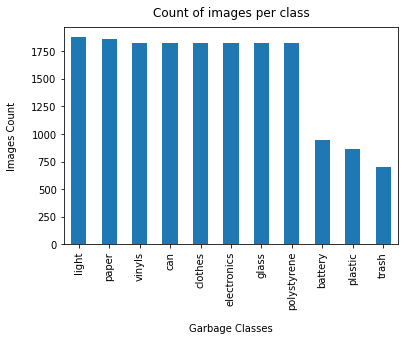

In [ ]:
df_visualization = df.copy()
# Change the catgegories from numbers to names
df_visualization['category'] = df_visualization['category'].apply(lambda x:categories[x] )

df_visualization['category'].value_counts().plot.bar(x = 'count', y = 'category' )

plt.xlabel("Garbage Classes", labelpad=14)
plt.ylabel("Images Count", labelpad=14)
plt.title("Count of images per class", y=1.02);

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
import keras.applications.xception as xception

xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS),
                       weights = '/content/drive/MyDrive/recycling_data/Xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')

# We don't want to train the imported weights
xception_layer.trainable = False


model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

#create a custom layer to apply the preprocessing
def xception_preprocessing(img):
  return xception.preprocess_input(img)

model.add(Lambda(xception_preprocessing))

model.add(xception_layer)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories), activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 320, 320, 3)       0         
                                                                 
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 11)                22539     
                                                                 
Total params: 20,884,019
Trainable params: 22,539
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor='val_categorical_accuracy' , mode='max', min_delta=0.001, restore_best_weights = True)
callbacks = [early_stop]

In [ ]:
#Change the categories from numbers to names
df["category"] = df["category"].replace(categories) 

# We first split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(df, test_size=0.2, random_state=42)
validate_df, test_df = train_test_split(validate_df, test_size=0.5, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

print('train size = ', total_train , 'validate size = ', total_validate, 'test size = ', test_df.shape[0])

train size =  13731 validate size =  1716 test size =  1717


In [ ]:
train_df.head()

,filename,category
0,glass/glass1642.jpg,glass
1,can/can1204.jpg,can
2,vinyls/vinyls28.jpg,vinyls
3,vinyls/vinyls923.jpg,vinyls
4,can/can474.jpg,can


In [ ]:
batch_size=64

train_datagen = image.ImageDataGenerator(

)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 13731 validated image filenames belonging to 11 classes.


In [ ]:
validation_datagen = image.ImageDataGenerator()

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1716 validated image filenames belonging to 11 classes.


In [ ]:
EPOCHS = 20
history = model.fit_generator(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


214/214 [==============================] - 5711s 27s/step - loss: 0.7209 - categorical_accuracy: 0.8068 - val_loss: 0.3917 - val_categorical_accuracy: 0.8882
Epoch 2/20
214/214 [==============================] - 571s 3s/step - loss: 0.3491 - categorical_accuracy: 0.8931 - val_loss: 0.3087 - val_categorical_accuracy: 0.9093
Epoch 3/20
214/214 [==============================] - 576s 3s/step - loss: 0.2850 - categorical_accuracy: 0.9098 - val_loss: 0.2767 - val_categorical_accuracy: 0.9141
Epoch 4/20
214/214 [==============================] - 576s 3s/step - loss: 0.2451 - categorical_accuracy: 0.9225 - val_loss: 0.2469 - val_categorical_accuracy: 0.9231
Epoch 5/20
214/214 [==============================] - 593s 3s/step - loss: 0.2211 - categorical_accuracy: 0.9302 - val_loss: 0.2326 - val_categorical_accuracy: 0.9291
Epoch 6/20
214/214 [==============================] - 574s 3s/step - loss: 0.2007 - categorical_accuracy: 0.9359 - val_loss: 0.2272 - val_categorical_accuracy: 0.9255
Epoch 7

In [ ]:
model.save_weights("model.h5")

In [ ]:
model.save('model_all.h5')

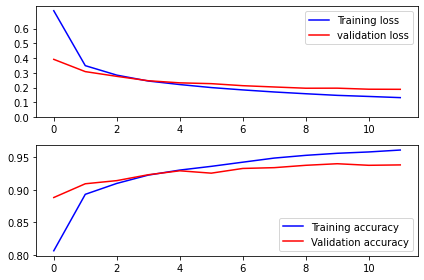

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_yticks(np.arange(0, 0.7, 0.1))
ax1.legend()

ax2.plot(history.history['categorical_accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_categorical_accuracy'], color='r',label="Validation accuracy")
ax2.legend()

legend = plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
test_datagen = image.ImageDataGenerator()

test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    batch_size=1,
    shuffle=False 
)

Found 1717 validated image filenames belonging to 11 classes.


In [ ]:
filenames = test_generator.filenames
nb_samples = len(filenames)

_, accuracy = model.evaluate_generator(test_generator, nb_samples)

print('accuracy on test set = ',  round((accuracy * 100),2 ), '% ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  after removing the cwd from sys.path.


accuracy on test set =  92.37 % 


In [ ]:
gen_label_map = test_generator.class_indices
gen_label_map = dict((v,k) for k,v in gen_label_map.items())
print(gen_label_map)

{0: 'battery', 1: 'can', 2: 'clothes', 3: 'electronics', 4: 'glass', 5: 'light', 6: 'paper', 7: 'plastic', 8: 'polystyrene', 9: 'trash', 10: 'vinyls'}


In [ ]:
# get the model's predictions for the test set
preds = model.predict_generator(test_generator, nb_samples)

# Get the category with the highest predicted probability, the prediction is only the category's number and not name
preds = preds.argmax(1)

# Convert the predicted category's number to name 
preds = [gen_label_map[item] for item in preds]

# Convert the pandas dataframe to a numpy matrix
labels = test_df['category'].to_numpy()

print(classification_report(labels, preds))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


              precision    recall  f1-score   support

     battery       1.00      0.97      0.99       104
         can       0.86      0.91      0.88       191
     clothes       0.95      1.00      0.97       203
 electronics       0.88      0.94      0.91       178
       glass       0.92      0.91      0.92       198
       light       0.98      0.96      0.97       187
       paper       0.88      0.82      0.85       179
     plastic       0.97      0.96      0.96        70
 polystyrene       0.95      0.95      0.95       171
       trash       0.98      0.98      0.98        65
      vinyls       0.88      0.82      0.85       171

    accuracy                           0.92      1717
   macro avg       0.93      0.93      0.93      1717
weighted avg       0.92      0.92      0.92      1717

